# Experimentación - MSTGCN



## 1. Obtención de datos



In [2]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import MSTGCNModel
from utils.trainer import  TrainerMSTGCN
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [15]:
def entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = device
    for nb_block, filter_, time_strides, hidden in tqdm(list(itertools.product(param_grid['nb_block'], param_grid['filter'], param_grid['time_strides'], param_grid['hidden']))):
        print(f"Entrenando modelo con nb_block={nb_block}, nb_chev_filter={filter_}, nb_time_filter={filter_}, time_strides={time_strides}")        
        model = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=nb_block, k=2, hidden=hidden, nb_chev_filter = filter_, nb_time_filter =filter_, time_strides = time_strides, is_classification=True)
        trainer = TrainerMSTGCN(model, dataset, device, f"../experimentos_split/results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "nb_block": nb_block,
            "nb_chev_filter": filter_,
            "nb_time_filter": filter_,
            "time_strides": time_strides,
            "hidden": hidden,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {
                "nb_block": nb_block,
                "nb_chev_filter": filter_,
                "nb_time_filter": filter_,
                "time_strides": time_strides, 
                "hidden": hidden
            }
            mejores_resultados = results_intermedio

        print("Parámetros: ", nb_block, filter_,  time_strides, hidden)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [19]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MSTGCNModel

In [20]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerMSTGCN

In [21]:

param_grid = {
    "nb_block": [1, 2, 3],
    "filter": [2,4,8],
    "time_strides": [2,5,10,20],
    "hidden":[20,50,80,100]
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_mstgcn(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "MSTGCN",target_names)

  0%|          | 0/144 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5698 | Eval Loss: 1.5285 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5663 | Eval Loss: 1.5406 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.5647 | Eval Loss: 1.5313 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.5649 | Eval Loss: 1.5329 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.5648 | Eval Loss: 1.5347 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 

  1%|          | 1/144 [01:20<3:11:23, 80.30s/it]

Epoch 52/100 | Train Loss: 1.5073 | Eval Loss: 1.4453 | Accuracy: 0.5200 | Precision: 0.2129 | Recall: 0.3429 | F1-Score: 0.2599 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.46        84
   macro avg       0.21      0.37      0.26        84
weighted avg       0.24      0.46      0.31        84

preds:  torch.Size([])
test loss: 1.498616, test accuracy: 0.4643, test precision: 0.2103, test recall: 0.3667, test F1-score: 0.2624
Parámetros:  1 2 2 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 20, 'Loss_final': 1.507345199584961, 'Accuracy_eval': 0.3

  1%|▏         | 2/144 [02:44<3:15:06, 82.44s/it]

Epoch 52/100 | Train Loss: 1.1590 | Eval Loss: 1.2969 | Accuracy: 0.6000 | Precision: 0.4293 | Recall: 0.4907 | F1-Score: 0.4520 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.44      0.33      0.38        12
           1       0.41      0.73      0.52        15
           2       0.30      0.33      0.32         9
           3       0.00      0.00      0.00        19
           4       0.68      0.90      0.78        29

    accuracy                           0.52        84
   macro avg       0.37      0.46      0.40        84
weighted avg       0.40      0.52      0.45        84

preds:  torch.Size([])
test loss: 1.363027, test accuracy: 0.5238, test precision: 0.3672, test recall: 0.4593, test F1-score: 0.3993
Parámetros:  1 2 2 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 50, 'Loss_final': 1.158976674079895, 'Accuracy_eval': 0.5

  2%|▏         | 3/144 [04:15<3:23:32, 86.61s/it]

Epoch 52/100 | Train Loss: 1.1620 | Eval Loss: 1.2414 | Accuracy: 0.6267 | Precision: 0.4692 | Recall: 0.5429 | F1-Score: 0.4948 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.00      0.00      0.00        15
           2       0.40      0.22      0.29         9
           3       1.00      1.00      1.00        19
           4       0.59      1.00      0.74        29

    accuracy                           0.68        84
   macro avg       0.53      0.56      0.53        84
weighted avg       0.56      0.68      0.60        84

preds:  torch.Size([])
test loss: 1.228220, test accuracy: 0.6786, test precision: 0.5256, test recall: 0.5611, test F1-score: 0.5276
Parámetros:  1 2 2 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 80, 'Loss_final': 1.1619999408721924, 'Accuracy_eval': 0.

  3%|▎         | 4/144 [05:55<3:33:44, 91.60s/it]

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.49        84
   macro avg       0.22      0.40      0.28        84
weighted avg       0.25      0.49      0.33        84

preds:  torch.Size([])
test loss: 1.416071, test accuracy: 0.4881, test precision: 0.2212, test recall: 0.4000, test F1-score: 0.2821
Parámetros:  1 2 2 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 100, 'Loss_final': 1.4101788997650146, 'Accuracy_eval': 0.5261538461538462, 'Precision_eval': 0.19880673121560916, 'Recall_eval': 0.34989010989010993, 'F1_eval': 0.25007556531423003, 'Loss_eval': 1.34286367893219, 'Loss_tst': 1.4160711765289307, 'Accurac

  3%|▎         | 5/144 [07:08<3:17:26, 85.23s/it]

Epoch 52/100 | Train Loss: 1.2104 | Eval Loss: 1.2910 | Accuracy: 0.6000 | Precision: 0.4271 | Recall: 0.4907 | F1-Score: 0.4498 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.42      0.67      0.51        15
           2       0.33      0.22      0.27         9
           3       0.00      0.00      0.00        19
           4       0.66      0.93      0.77        29

    accuracy                           0.56        84
   macro avg       0.40      0.50      0.44        84
weighted avg       0.43      0.56      0.48        84

preds:  torch.Size([])
test loss: 1.339147, test accuracy: 0.5595, test precision: 0.4048, test recall: 0.4973, test F1-score: 0.4382
Parámetros:  1 2 5 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 20, 'Loss_final': 1.2104405164718628, 'Accuracy_eval': 0.

  4%|▍         | 6/144 [08:22<3:07:09, 81.37s/it]

Epoch 52/100 | Train Loss: 1.5635 | Eval Loss: 1.5308 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554832, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  1 2 5 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 50, 'Loss_final': 1.5635024309158325, 'Accuracy_eval': 0.

  5%|▍         | 7/144 [09:35<2:59:08, 78.46s/it]

Epoch 52/100 | Train Loss: 1.5639 | Eval Loss: 1.5310 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.555212, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  1 2 5 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 80, 'Loss_final': 1.5638964176177979, 'Accuracy_eval': 0.

  6%|▌         | 8/144 [10:47<2:53:34, 76.58s/it]

Epoch 52/100 | Train Loss: 1.1797 | Eval Loss: 1.2422 | Accuracy: 0.6667 | Precision: 0.6342 | Recall: 0.5943 | F1-Score: 0.5942 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.37      0.47      0.41        15
           2       0.38      0.33      0.35         9
           3       0.25      0.05      0.09        19
           4       0.68      0.97      0.80        29

    accuracy                           0.56        84
   macro avg       0.47      0.50      0.46        84
weighted avg       0.49      0.56      0.50        84

preds:  torch.Size([])
test loss: 1.306176, test accuracy: 0.5595, test precision: 0.4686, test recall: 0.4970, test F1-score: 0.4637
Parámetros:  1 2 5 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 100, 'Loss_final': 1.1796636581420898, 'Accuracy_eval': 

  6%|▋         | 9/144 [11:54<2:45:10, 73.41s/it]

Epoch 52/100 | Train Loss: 1.5631 | Eval Loss: 1.5303 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554304, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  1 2 10 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 20, 'Loss_final': 1.5631262063980103, 'Accuracy_eval': 

  7%|▋         | 10/144 [13:01<2:39:40, 71.49s/it]

Epoch 52/100 | Train Loss: 1.2624 | Eval Loss: 1.3555 | Accuracy: 0.6133 | Precision: 0.5509 | Recall: 0.5431 | F1-Score: 0.5455 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.54      0.47      0.50        15
           2       0.45      0.56      0.50         9
           3       1.00      0.47      0.64        19
           4       0.62      0.83      0.71        29

    accuracy                           0.64        84
   macro avg       0.67      0.61      0.62        84
weighted avg       0.69      0.64      0.64        84

preds:  torch.Size([])
test loss: 1.322023, test accuracy: 0.6429, test precision: 0.6717, test recall: 0.6147, test F1-score: 0.6197
Parámetros:  1 2 10 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 50, 'Loss_final': 1.2624351978302002, 'Accuracy_eval': 

  8%|▊         | 11/144 [14:08<2:35:20, 70.08s/it]

Epoch 52/100 | Train Loss: 1.2620 | Eval Loss: 1.2793 | Accuracy: 0.6133 | Precision: 0.4526 | Recall: 0.5360 | F1-Score: 0.4850 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       0.00      0.00      0.00        15
           2       0.67      0.22      0.33         9
           3       0.95      0.95      0.95        19
           4       0.66      1.00      0.79        29

    accuracy                           0.71        84
   macro avg       0.58      0.62      0.56        84
weighted avg       0.60      0.71      0.63        84

preds:  torch.Size([])
test loss: 1.253733, test accuracy: 0.7143, test precision: 0.5768, test recall: 0.6173, test F1-score: 0.5617
Parámetros:  1 2 10 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 80, 'Loss_final': 1.262012243270874, 'Accuracy_eval': 0

  8%|▊         | 12/144 [15:14<2:31:45, 68.98s/it]

Epoch 52/100 | Train Loss: 1.5637 | Eval Loss: 1.5309 | Accuracy: 0.3867 | Precision: 0.0773 | Recall: 0.2000 | F1-Score: 0.1115 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.555081, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  1 2 10 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 100, 'Loss_final': 1.5637141466140747, 'Accuracy_eval'

  9%|▉         | 13/144 [16:18<2:26:59, 67.32s/it]

Epoch 52/100 | Train Loss: 1.3294 | Eval Loss: 1.3074 | Accuracy: 0.5867 | Precision: 0.3337 | Recall: 0.4912 | F1-Score: 0.3893 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.50      0.92      0.65        12
           1       0.34      0.73      0.47        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.67      0.69      0.68        29

    accuracy                           0.50        84
   macro avg       0.30      0.47      0.36        84
weighted avg       0.36      0.50      0.41        84

preds:  torch.Size([])
test loss: 1.397687, test accuracy: 0.5000, test precision: 0.3021, test recall: 0.4679, test F1-score: 0.3586
Parámetros:  1 2 20 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 20, 'Loss_final': 1.3294286727905273, 'Accuracy_eval': 

 10%|▉         | 14/144 [17:21<2:23:25, 66.20s/it]

Epoch 52/100 | Train Loss: 1.3857 | Eval Loss: 1.3587 | Accuracy: 0.5333 | Precision: 0.2536 | Recall: 0.3571 | F1-Score: 0.2841 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.00      0.00      0.00        15
           2       0.25      0.22      0.24         9
           3       0.00      0.00      0.00        19
           4       0.46      0.97      0.62        29

    accuracy                           0.46        84
   macro avg       0.26      0.39      0.30        84
weighted avg       0.27      0.46      0.34        84

preds:  torch.Size([])
test loss: 1.417460, test accuracy: 0.4643, test precision: 0.2618, test recall: 0.3875, test F1-score: 0.3048
Parámetros:  1 2 20 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 50, 'Loss_final': 1.3857197761535645, 'Accuracy_eval': 

 10%|█         | 15/144 [18:12<2:12:21, 61.56s/it]

Epoch 52/100 | Train Loss: 1.4413 | Eval Loss: 1.3729 | Accuracy: 0.5600 | Precision: 0.2184 | Recall: 0.3857 | F1-Score: 0.2787 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  torch.Size([])
test loss: 1.434093, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  1 2 20 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 80, 'Loss_final': 1.4412559270858765, 'Accuracy_eval': 

 11%|█         | 16/144 [18:55<1:59:15, 55.91s/it]

Epoch 52/100 | Train Loss: 1.3353 | Eval Loss: 1.3161 | Accuracy: 0.5867 | Precision: 0.3335 | Recall: 0.4912 | F1-Score: 0.3905 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.48      0.92      0.63        12
           1       0.37      0.73      0.49        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.65      0.69      0.67        29

    accuracy                           0.50        84
   macro avg       0.30      0.47      0.36        84
weighted avg       0.36      0.50      0.41        84

preds:  torch.Size([])
test loss: 1.391611, test accuracy: 0.5000, test precision: 0.2980, test recall: 0.4679, test F1-score: 0.3568
Parámetros:  1 2 20 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 100, 'Loss_final': 1.3353452682495117, 'Accuracy_eval'

 12%|█▏        | 17/144 [20:11<2:11:14, 62.00s/it]

Epoch 52/100 | Train Loss: 1.1992 | Eval Loss: 1.2822 | Accuracy: 0.6133 | Precision: 0.4593 | Recall: 0.5124 | F1-Score: 0.4662 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.36      0.67      0.47        15
           2       0.43      0.33      0.38         9
           3       0.00      0.00      0.00        19
           4       0.69      0.83      0.75        29

    accuracy                           0.55        84
   macro avg       0.42      0.52      0.46        84
weighted avg       0.44      0.55      0.48        84

preds:  torch.Size([])
test loss: 1.346754, test accuracy: 0.5476, test precision: 0.4229, test recall: 0.5155, test F1-score: 0.4565
Parámetros:  1 4 2 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 20, 'Loss_final': 1.1991856098175049, 'Accuracy_eval': 0.

 12%|█▎        | 18/144 [21:29<2:20:15, 66.79s/it]

Epoch 52/100 | Train Loss: 1.3440 | Eval Loss: 1.3424 | Accuracy: 0.5467 | Precision: 0.2990 | Recall: 0.3714 | F1-Score: 0.3083 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.00      0.00      0.00        15
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.46        84
   macro avg       0.26      0.37      0.29        84
weighted avg       0.27      0.46      0.32        84

preds:  torch.Size([])
test loss: 1.433042, test accuracy: 0.4643, test precision: 0.2592, test recall: 0.3722, test F1-score: 0.2875
Parámetros:  1 4 2 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 50, 'Loss_final': 1.3440008163452148, 'Accuracy_eval': 0.

 13%|█▎        | 19/144 [22:48<2:26:50, 70.48s/it]

Epoch 52/100 | Train Loss: 1.3449 | Eval Loss: 1.3444 | Accuracy: 0.5333 | Precision: 0.2851 | Recall: 0.3571 | F1-Score: 0.3046 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.00      0.00      0.00        15
           2       0.33      0.33      0.33         9
           3       0.00      0.00      0.00        19
           4       0.45      0.97      0.62        29

    accuracy                           0.46        84
   macro avg       0.28      0.39      0.32        84
weighted avg       0.28      0.46      0.34        84

preds:  torch.Size([])
test loss: 1.423097, test accuracy: 0.4643, test precision: 0.2801, test recall: 0.3931, test F1-score: 0.3177
Parámetros:  1 4 2 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 80, 'Loss_final': 1.344939947128296, 'Accuracy_eval': 0.5

 14%|█▍        | 20/144 [24:07<2:30:58, 73.05s/it]

Epoch 52/100 | Train Loss: 1.3801 | Eval Loss: 1.3303 | Accuracy: 0.5600 | Precision: 0.3248 | Recall: 0.3857 | F1-Score: 0.3300 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.00      0.00      0.00        15
           2       0.33      0.11      0.17         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.48        84
   macro avg       0.28      0.39      0.30        84
weighted avg       0.28      0.48      0.33        84

preds:  torch.Size([])
test loss: 1.425377, test accuracy: 0.4762, test precision: 0.2809, test recall: 0.3889, test F1-score: 0.2996
Parámetros:  1 4 2 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 100, 'Loss_final': 1.3801403045654297, 'Accuracy_eval': 

 15%|█▍        | 21/144 [25:04<2:19:49, 68.21s/it]

Epoch 52/100 | Train Loss: 1.2390 | Eval Loss: 1.2833 | Accuracy: 0.6267 | Precision: 0.4548 | Recall: 0.5193 | F1-Score: 0.4639 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.40      0.67      0.50        15
           2       0.29      0.22      0.25         9
           3       0.00      0.00      0.00        19
           4       0.68      0.90      0.78        29

    accuracy                           0.55        84
   macro avg       0.39      0.49      0.43        84
weighted avg       0.42      0.55      0.47        84

preds:  torch.Size([])
test loss: 1.336011, test accuracy: 0.5476, test precision: 0.3883, test recall: 0.4904, test F1-score: 0.4283
Parámetros:  1 4 5 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 20, 'Loss_final': 1.2389729022979736, 'Accuracy_eval': 0.

 15%|█▌        | 22/144 [26:11<2:17:51, 67.80s/it]

Epoch 52/100 | Train Loss: 1.1395 | Eval Loss: 1.2600 | Accuracy: 0.6400 | Precision: 0.5532 | Recall: 0.5460 | F1-Score: 0.5353 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.43      0.67      0.53        15
           2       0.38      0.33      0.35         9
           3       0.60      0.16      0.25        19
           4       0.72      0.90      0.80        29

    accuracy                           0.60        84
   macro avg       0.56      0.54      0.52        84
weighted avg       0.60      0.60      0.56        84

preds:  torch.Size([])
test loss: 1.318229, test accuracy: 0.5952, test precision: 0.5597, test recall: 0.5442, test F1-score: 0.5192
Parámetros:  1 4 5 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 50, 'Loss_final': 1.1394931077957153, 'Accuracy_eval': 0.

 16%|█▌        | 23/144 [27:28<2:22:02, 70.43s/it]

Epoch 52/100 | Train Loss: 1.3384 | Eval Loss: 1.3334 | Accuracy: 0.5733 | Precision: 0.3394 | Recall: 0.4000 | F1-Score: 0.3571 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.00      0.00      0.00        15
           2       0.50      0.33      0.40         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.50        84
   macro avg       0.33      0.43      0.35        84
weighted avg       0.31      0.50      0.37        84

preds:  torch.Size([])
test loss: 1.418606, test accuracy: 0.5000, test precision: 0.3254, test recall: 0.4333, test F1-score: 0.3542
Parámetros:  1 4 5 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 80, 'Loss_final': 1.3383904695510864, 'Accuracy_eval': 0.

 17%|█▋        | 24/144 [28:51<2:28:38, 74.32s/it]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.38      0.73      0.50        15
           2       0.40      0.22      0.29         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.42      0.52      0.45        84
weighted avg       0.44      0.56      0.48        84

preds:  torch.Size([])
test loss: 1.346728, test accuracy: 0.5595, test precision: 0.4220, test recall: 0.5233, test F1-score: 0.4524
Parámetros:  1 4 5 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 100, 'Loss_final': 1.1941463947296143, 'Accuracy_eval': 0.5853846153846154, 'Precision_eval': 0.40934769968720003, 'Recall_eval': 0.47005494505494505, 'F1_eval': 0.4049036612625291, 'Loss_eval': 1.283707857131958, 'Loss_tst': 1.3467276096343994, 'Accurac

 17%|█▋        | 25/144 [30:01<2:24:40, 72.94s/it]

Epoch 52/100 | Train Loss: 1.2089 | Eval Loss: 1.2925 | Accuracy: 0.6133 | Precision: 0.5461 | Recall: 0.5388 | F1-Score: 0.5316 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.42      0.53      0.47        15
           2       0.25      0.11      0.15         9
           3       0.50      0.26      0.34        19
           4       0.68      0.86      0.76        29

    accuracy                           0.57        84
   macro avg       0.50      0.50      0.48        84
weighted avg       0.54      0.57      0.54        84

preds:  torch.Size([])
test loss: 1.298586, test accuracy: 0.5714, test precision: 0.4979, test recall: 0.5039, test F1-score: 0.4838
Parámetros:  1 4 10 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 20, 'Loss_final': 1.2089465856552124, 'Accuracy_eval': 

 18%|█▊        | 26/144 [31:12<2:22:33, 72.49s/it]

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.39      0.60      0.47        15
           2       0.33      0.33      0.33         9
           3       0.33      0.11      0.16        19
           4       0.68      0.86      0.76        29

    accuracy                           0.54        84
   macro avg       0.48      0.48      0.46        84
weighted avg       0.51      0.54      0.50        84

preds:  torch.Size([])
test loss: 1.338423, test accuracy: 0.5357, test precision: 0.4801, test recall: 0.4801, test F1-score: 0.4592
Parámetros:  1 4 10 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 50, 'Loss_final': 1.1814022064208984, 'Accuracy_eval': 0.6056410256410256, 'Precision_eval': 0.4045816532553851, 'Recall_eval': 0.4811893709738537, 'F1_eval': 0.4187793624319119, 'Loss_eval': 1.2558465003967285, 'Loss_tst': 1.3384230136871338, 'Accuracy

 19%|█▉        | 27/144 [32:24<2:20:59, 72.30s/it]

Epoch 52/100 | Train Loss: 1.1985 | Eval Loss: 1.2990 | Accuracy: 0.5867 | Precision: 0.4228 | Recall: 0.4838 | F1-Score: 0.4412 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.41      0.73      0.52        15
           2       0.38      0.33      0.35         9
           3       0.00      0.00      0.00        19
           4       0.72      0.90      0.80        29

    accuracy                           0.57        84
   macro avg       0.42      0.53      0.46        84
weighted avg       0.45      0.57      0.50        84

preds:  torch.Size([])
test loss: 1.325635, test accuracy: 0.5714, test precision: 0.4240, test recall: 0.5260, test F1-score: 0.4634
Parámetros:  1 4 10 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 80, 'Loss_final': 1.1985101699829102, 'Accuracy_eval': 

 19%|█▉        | 28/144 [33:36<2:19:42, 72.27s/it]

Epoch 52/100 | Train Loss: 1.2122 | Eval Loss: 1.3043 | Accuracy: 0.5733 | Precision: 0.3994 | Recall: 0.4696 | F1-Score: 0.4230 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.37      0.67      0.48        15
           2       0.40      0.44      0.42         9
           3       0.00      0.00      0.00        19
           4       0.71      0.86      0.78        29

    accuracy                           0.56        84
   macro avg       0.43      0.53      0.47        84
weighted avg       0.45      0.56      0.50        84

preds:  torch.Size([])
test loss: 1.344846, test accuracy: 0.5595, test precision: 0.4303, test recall: 0.5280, test F1-score: 0.4690
Parámetros:  1 4 10 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 100, 'Loss_final': 1.2121814489364624, 'Accuracy_eval'

 20%|██        | 29/144 [34:45<2:16:32, 71.24s/it]

Epoch 52/100 | Train Loss: 1.3859 | Eval Loss: 1.3356 | Accuracy: 0.5600 | Precision: 0.3228 | Recall: 0.3857 | F1-Score: 0.3033 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.00      0.00      0.00        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.49        84
   macro avg       0.32      0.41      0.33        84
weighted avg       0.30      0.49      0.35        84

preds:  torch.Size([])
test loss: 1.416141, test accuracy: 0.4881, test precision: 0.3226, test recall: 0.4111, test F1-score: 0.3331
Parámetros:  1 4 20 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 20, 'hidden': 20, 'Loss_final': 1.3858839273452759, 'Accuracy_eval': 

 21%|██        | 30/144 [35:40<2:05:50, 66.23s/it]

Epoch 52/100 | Train Loss: 1.3346 | Eval Loss: 1.3447 | Accuracy: 0.5200 | Precision: 0.2744 | Recall: 0.3429 | F1-Score: 0.2965 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.00      0.00      0.00        15
           2       0.40      0.44      0.42         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.46        84
   macro avg       0.29      0.39      0.32        84
weighted avg       0.29      0.46      0.34        84

preds:  torch.Size([])
test loss: 1.443473, test accuracy: 0.4643, test precision: 0.2906, test recall: 0.3889, test F1-score: 0.3180
Parámetros:  1 4 20 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 20, 'hidden': 50, 'Loss_final': 1.3345725536346436, 'Accuracy_eval': 

 22%|██▏       | 31/144 [36:32<1:56:43, 61.98s/it]

Epoch 52/100 | Train Loss: 1.3815 | Eval Loss: 1.3200 | Accuracy: 0.5600 | Precision: 0.2853 | Recall: 0.3857 | F1-Score: 0.3164 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.00      0.00      0.00        15
           2       0.22      0.22      0.22         9
           3       0.00      0.00      0.00        19
           4       0.46      0.97      0.62        29

    accuracy                           0.45        84
   macro avg       0.25      0.37      0.29        84
weighted avg       0.26      0.45      0.33        84

preds:  torch.Size([])
test loss: 1.422698, test accuracy: 0.4524, test precision: 0.2505, test recall: 0.3709, test F1-score: 0.2920
Parámetros:  1 4 20 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 20, 'hidden': 80, 'Loss_final': 1.3814579248428345, 'Accuracy_eval': 

 22%|██▏       | 32/144 [37:25<1:50:44, 59.33s/it]

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.38      0.67      0.49        15
           2       0.50      0.33      0.40         9
           3       0.00      0.00      0.00        19
           4       0.67      0.90      0.76        29

    accuracy                           0.57        84
   macro avg       0.46      0.53      0.48        84
weighted avg       0.46      0.57      0.50        84

preds:  torch.Size([])
test loss: 1.331601, test accuracy: 0.5714, test precision: 0.4603, test recall: 0.5293, test F1-score: 0.4805
Parámetros:  1 4 20 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 20, 'hidden': 100, 'Loss_final': 1.2115585803985596, 'Accuracy_eval': 0.5838461538461539, 'Precision_eval': 0.36152695648673977, 'Recall_eval': 0.46789124668435017, 'F1_eval': 0.38964271068148715, 'Loss_eval': 1.2973881959915161, 'Loss_tst': 1.3316010236740112, 'Acc

 23%|██▎       | 33/144 [39:02<2:10:35, 70.59s/it]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.00      0.00      0.00        15
           2       0.29      0.22      0.25         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.46        84
   macro avg       0.28      0.38      0.31        84
weighted avg       0.28      0.46      0.34        84

preds:  torch.Size([])
test loss: 1.432010, test accuracy: 0.4643, test precision: 0.2797, test recall: 0.3778, test F1-score: 0.3067
Parámetros:  1 8 2 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 20, 'Loss_final': 1.33133065700531, 'Accuracy_eval': 0.5561538461538461, 'Precision_eval': 0.31691693428181256, 'Recall_eval': 0.38159340659340657, 'F1_eval': 0.31337559007852567, 'Loss_eval': 1.3256597518920898, 'Loss_tst': 1.4320100545883179, 'Accuracy_

 24%|██▎       | 34/144 [40:45<2:27:28, 80.44s/it]

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.67      0.67      0.67        15
           2       0.33      0.11      0.17         9
           3       0.89      0.84      0.86        19
           4       0.76      0.86      0.81        29

    accuracy                           0.74        84
   macro avg       0.66      0.66      0.65        84
weighted avg       0.71      0.74      0.72        84

preds:  torch.Size([])
test loss: 1.180660, test accuracy: 0.7381, test precision: 0.6626, test recall: 0.6631, test F1-score: 0.6491
Parámetros:  1 8 2 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 50, 'Loss_final': 1.0736368894577026, 'Accuracy_eval': 0.6217948717948718, 'Precision_eval': 0.4903858274585688, 'Recall_eval': 0.5334586964759379, 'F1_eval': 0.49076241090423867, 'Loss_eval': 1.2155059576034546, 'Loss_tst': 1.1806596517562866, 'Accuracy_

 24%|██▍       | 35/144 [42:31<2:40:14, 88.20s/it]

              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.00      0.00      0.00        15
           2       0.30      0.33      0.32         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.44        84
   macro avg       0.26      0.35      0.28        84
weighted avg       0.27      0.44      0.31        84

preds:  torch.Size([])
test loss: 1.462485, test accuracy: 0.4405, test precision: 0.2603, test recall: 0.3500, test F1-score: 0.2818
Parámetros:  1 8 2 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 80, 'Loss_final': 1.3004858493804932, 'Accuracy_eval': 0.5615384615384617, 'Precision_eval': 0.2896608434079354, 'Recall_eval': 0.38764683592269783, 'F1_eval': 0.3158192483411889, 'Loss_eval': 1.3232316970825195, 'Loss_tst': 1.46248459815979, 'Accuracy_ts

 25%|██▌       | 36/144 [44:19<2:49:11, 93.99s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.559594, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  1 8 2 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 100, 'Loss_final': 1.5785824060440063, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.518165946006775, 'Loss_tst': 1.5595942735671997, 'Accur

 26%|██▌       | 37/144 [45:27<2:34:00, 86.36s/it]

Epoch 52/100 | Train Loss: 1.3446 | Eval Loss: 1.3431 | Accuracy: 0.5200 | Precision: 0.2620 | Recall: 0.3429 | F1-Score: 0.2849 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.00      0.00      0.00        15
           2       0.50      0.33      0.40         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.50        84
   macro avg       0.33      0.43      0.35        84
weighted avg       0.31      0.50      0.37        84

preds:  torch.Size([])
test loss: 1.414191, test accuracy: 0.5000, test precision: 0.3254, test recall: 0.4333, test F1-score: 0.3542
Parámetros:  1 8 5 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 5, 'hidden': 20, 'Loss_final': 1.3446260690689087, 'Accuracy_eval': 0.

 26%|██▋       | 38/144 [46:39<2:24:30, 81.80s/it]

Epoch 52/100 | Train Loss: 1.2698 | Eval Loss: 1.2692 | Accuracy: 0.6533 | Precision: 0.5048 | Recall: 0.5907 | F1-Score: 0.5324 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.40      0.53      0.46        15
           2       0.35      0.78      0.48         9
           3       0.38      0.16      0.22        19
           4       0.72      0.90      0.80        29

    accuracy                           0.52        84
   macro avg       0.37      0.47      0.39        84
weighted avg       0.44      0.52      0.46        84

preds:  torch.Size([])
test loss: 1.364002, test accuracy: 0.5238, test precision: 0.3694, test recall: 0.4731, test F1-score: 0.3924
Parámetros:  1 8 5 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 5, 'hidden': 50, 'Loss_final': 1.2697622776031494, 'Accuracy_eval': 0.

 27%|██▋       | 39/144 [47:50<2:17:47, 78.74s/it]

Epoch 52/100 | Train Loss: 1.2166 | Eval Loss: 1.2975 | Accuracy: 0.5867 | Precision: 0.4058 | Recall: 0.4838 | F1-Score: 0.4262 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.37      0.67      0.48        15
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00        19
           4       0.66      0.86      0.75        29

    accuracy                           0.54        84
   macro avg       0.38      0.48      0.41        84
weighted avg       0.41      0.54      0.45        84

preds:  torch.Size([])
test loss: 1.353436, test accuracy: 0.5357, test precision: 0.3757, test recall: 0.4780, test F1-score: 0.4086
Parámetros:  1 8 5 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 5, 'hidden': 80, 'Loss_final': 1.2165660858154297, 'Accuracy_eval': 0.

 28%|██▊       | 40/144 [49:04<2:13:41, 77.13s/it]

Epoch 52/100 | Train Loss: 1.1766 | Eval Loss: 1.2152 | Accuracy: 0.6933 | Precision: 0.5610 | Recall: 0.6657 | F1-Score: 0.6016 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.67      0.67      0.67        15
           2       0.37      0.78      0.50         9
           3       0.85      0.89      0.87        19
           4       0.83      0.86      0.85        29

    accuracy                           0.70        84
   macro avg       0.54      0.64      0.58        84
weighted avg       0.64      0.70      0.66        84

preds:  torch.Size([])
test loss: 1.219267, test accuracy: 0.7024, test precision: 0.5437, test recall: 0.6403, test F1-score: 0.5772
Parámetros:  1 8 5 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 5, 'hidden': 100, 'Loss_final': 1.176570177078247, 'Accuracy_eval': 0

 28%|██▊       | 41/144 [50:07<2:05:24, 73.06s/it]

Epoch 52/100 | Train Loss: 1.1867 | Eval Loss: 1.2897 | Accuracy: 0.6133 | Precision: 0.4160 | Recall: 0.5150 | F1-Score: 0.4537 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       0.45      0.60      0.51        15
           2       0.00      0.00      0.00         9
           3       0.62      0.26      0.37        19
           4       0.68      0.90      0.78        29

    accuracy                           0.62        84
   macro avg       0.49      0.55      0.49        84
weighted avg       0.55      0.62      0.56        84

preds:  torch.Size([])
test loss: 1.282565, test accuracy: 0.6190, test precision: 0.4852, test recall: 0.5519, test F1-score: 0.4922
Parámetros:  1 8 10 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 10, 'hidden': 20, 'Loss_final': 1.1866556406021118, 'Accuracy_eval': 

 29%|██▉       | 42/144 [51:11<1:59:32, 70.32s/it]

Epoch 52/100 | Train Loss: 1.1741 | Eval Loss: 1.2648 | Accuracy: 0.6400 | Precision: 0.4804 | Recall: 0.5336 | F1-Score: 0.4969 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.40      0.67      0.50        15
           2       0.44      0.44      0.44         9
           3       0.00      0.00      0.00        19
           4       0.71      0.93      0.81        29

    accuracy                           0.58        84
   macro avg       0.46      0.54      0.49        84
weighted avg       0.47      0.58      0.51        84

preds:  torch.Size([])
test loss: 1.313353, test accuracy: 0.5833, test precision: 0.4564, test recall: 0.5418, test F1-score: 0.4892
Parámetros:  1 8 10 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 10, 'hidden': 50, 'Loss_final': 1.1741348505020142, 'Accuracy_eval': 

 30%|██▉       | 43/144 [52:15<1:54:53, 68.26s/it]

Epoch 52/100 | Train Loss: 1.3419 | Eval Loss: 1.3424 | Accuracy: 0.5467 | Precision: 0.3049 | Recall: 0.3714 | F1-Score: 0.3231 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.00      0.00      0.00        15
           2       0.33      0.22      0.27         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.48        84
   macro avg       0.28      0.39      0.31        84
weighted avg       0.28      0.48      0.34        84

preds:  torch.Size([])
test loss: 1.424067, test accuracy: 0.4762, test precision: 0.2787, test recall: 0.3944, test F1-score: 0.3128
Parámetros:  1 8 10 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 10, 'hidden': 80, 'Loss_final': 1.3418632745742798, 'Accuracy_eval': 

 31%|███       | 44/144 [53:17<1:51:00, 66.61s/it]

Epoch 52/100 | Train Loss: 1.1937 | Eval Loss: 1.3017 | Accuracy: 0.6133 | Precision: 0.4575 | Recall: 0.5124 | F1-Score: 0.4720 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.39      0.73      0.51        15
           2       0.44      0.44      0.44         9
           3       0.00      0.00      0.00        19
           4       0.71      0.86      0.78        29

    accuracy                           0.57        84
   macro avg       0.44      0.54      0.48        84
weighted avg       0.46      0.57      0.50        84

preds:  torch.Size([])
test loss: 1.335624, test accuracy: 0.5714, test precision: 0.4437, test recall: 0.5413, test F1-score: 0.4808
Parámetros:  1 8 10 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 10, 'hidden': 100, 'Loss_final': 1.193741798400879, 'Accuracy_eval':

 31%|███▏      | 45/144 [54:13<1:44:39, 63.43s/it]

Epoch 52/100 | Train Loss: 1.2394 | Eval Loss: 1.2847 | Accuracy: 0.5733 | Precision: 0.3386 | Recall: 0.4696 | F1-Score: 0.3899 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.39      0.73      0.51        15
           2       0.33      0.11      0.17         9
           3       0.00      0.00      0.00        19
           4       0.68      0.86      0.76        29

    accuracy                           0.56        84
   macro avg       0.41      0.51      0.43        84
weighted avg       0.43      0.56      0.47        84

preds:  torch.Size([])
test loss: 1.338299, test accuracy: 0.5595, test precision: 0.4054, test recall: 0.5080, test F1-score: 0.4300
Parámetros:  1 8 20 20
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 20, 'hidden': 20, 'Loss_final': 1.2394365072250366, 'Accuracy_eval': 

 32%|███▏      | 46/144 [55:10<1:40:16, 61.39s/it]

Epoch 52/100 | Train Loss: 1.1355 | Eval Loss: 1.2889 | Accuracy: 0.6000 | Precision: 0.5094 | Recall: 0.5138 | F1-Score: 0.5005 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        12
           1       0.44      0.53      0.48        15
           2       0.29      0.22      0.25         9
           3       0.60      0.32      0.41        19
           4       0.68      0.90      0.78        29

    accuracy                           0.58        84
   macro avg       0.53      0.51      0.51        84
weighted avg       0.57      0.58      0.56        84

preds:  torch.Size([])
test loss: 1.272994, test accuracy: 0.5833, test precision: 0.5301, test recall: 0.5102, test F1-score: 0.5067
Parámetros:  1 8 20 50
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 20, 'hidden': 50, 'Loss_final': 1.1354703903198242, 'Accuracy_eval': 

 33%|███▎      | 47/144 [56:07<1:37:16, 60.17s/it]

Epoch 52/100 | Train Loss: 1.2282 | Eval Loss: 1.3038 | Accuracy: 0.6000 | Precision: 0.3554 | Recall: 0.4907 | F1-Score: 0.4104 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.38      0.67      0.49        15
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00        19
           4       0.68      0.93      0.78        29

    accuracy                           0.56        84
   macro avg       0.39      0.49      0.42        84
weighted avg       0.42      0.56      0.47        84

preds:  torch.Size([])
test loss: 1.331990, test accuracy: 0.5595, test precision: 0.3905, test recall: 0.4918, test F1-score: 0.4233
Parámetros:  1 8 20 80
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 20, 'hidden': 80, 'Loss_final': 1.2281862497329712, 'Accuracy_eval': 

 33%|███▎      | 48/144 [57:08<1:36:33, 60.35s/it]

Epoch 52/100 | Train Loss: 1.1136 | Eval Loss: 1.2957 | Accuracy: 0.6000 | Precision: 0.5297 | Recall: 0.5246 | F1-Score: 0.5191 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.56      0.67      0.61        15
           2       0.33      0.33      0.33         9
           3       0.82      0.47      0.60        19
           4       0.71      0.83      0.76        29

    accuracy                           0.62        84
   macro avg       0.58      0.56      0.56        84
weighted avg       0.64      0.62      0.61        84

preds:  torch.Size([])
test loss: 1.282013, test accuracy: 0.6190, test precision: 0.5826, test recall: 0.5603, test F1-score: 0.5603
Parámetros:  1 8 20 100
Resultados:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 20, 'hidden': 100, 'Loss_final': 1.1135571002960205, 'Accuracy_eval'

 34%|███▍      | 49/144 [59:25<2:12:03, 83.41s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554625, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 2 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 20, 'Loss_final': 1.5636370182037354, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.5312288999557495, 'Loss_tst': 1.554625391960144, 'Accurac

 35%|███▍      | 50/144 [1:01:31<2:30:24, 96.00s/it]

              precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.00      0.00      0.00        15
           2       0.30      0.33      0.32         9
           3       1.00      0.95      0.97        19
           4       0.63      1.00      0.77        29

    accuracy                           0.65        84
   macro avg       0.49      0.54      0.50        84
weighted avg       0.55      0.65      0.59        84

preds:  torch.Size([])
test loss: 1.239515, test accuracy: 0.6548, test precision: 0.4861, test recall: 0.5395, test F1-score: 0.5033
Parámetros:  2 2 2 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 50, 'Loss_final': 1.158581256866455, 'Accuracy_eval': 0.5635897435897436, 'Precision_eval': 0.3523015735887914, 'Recall_eval': 0.44574649488442597, 'F1_eval': 0.37508173660475713, 'Loss_eval': 1.2311091423034668, 'Loss_tst': 1.2395150661468506, 'Accuracy_

 35%|███▌      | 51/144 [1:03:34<2:41:38, 104.29s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.52      0.93      0.67        15
           2       0.36      0.89      0.52         9
           3       0.94      0.84      0.89        19
           4       0.94      0.59      0.72        29

    accuracy                           0.65        84
   macro avg       0.55      0.65      0.56        84
weighted avg       0.67      0.65      0.63        84

preds:  torch.Size([])
test loss: 1.295061, test accuracy: 0.6548, test precision: 0.5536, test recall: 0.6501, test F1-score: 0.5590
Parámetros:  2 2 2 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 80, 'Loss_final': 1.2752151489257812, 'Accuracy_eval': 0.4535897435897436, 'Precision_eval': 0.17127592146076914, 'Recall_eval': 0.29564039408867, 'F1_eval': 0.2086684567140478, 'Loss_eval': 1.330700397491455, 'Loss_tst': 1.2950612306594849, 'Accuracy_tst

 36%|███▌      | 52/144 [1:05:39<2:49:14, 110.37s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.48      0.67      0.56        15
           2       0.00      0.00      0.00         9
           3       0.60      0.32      0.41        19
           4       0.69      0.86      0.77        29

    accuracy                           0.62        84
   macro avg       0.48      0.55      0.50        84
weighted avg       0.55      0.62      0.57        84

preds:  torch.Size([])
test loss: 1.286163, test accuracy: 0.6190, test precision: 0.4835, test recall: 0.5522, test F1-score: 0.4994
Parámetros:  2 2 2 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'hidden': 100, 'Loss_final': 1.1913045644760132, 'Accuracy_eval': 0.5030769230769231, 'Precision_eval': 0.26540187359380973, 'Recall_eval': 0.36220917014020465, 'F1_eval': 0.29249342695633807, 'Loss_eval': 1.2939773797988892, 'Loss_tst': 1.2861629724502563, 'Accur

 37%|███▋      | 53/144 [1:07:08<2:37:30, 103.86s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554912, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 5 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 20, 'Loss_final': 1.5634204149246216, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.5307142734527588, 'Loss_tst': 1.5549116134643555, 'Accura

 38%|███▊      | 54/144 [1:08:38<2:29:56, 99.96s/it] 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554987, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 5 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 50, 'Loss_final': 1.5637248754501343, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.530900478363037, 'Loss_tst': 1.554986834526062, 'Accuracy

 38%|███▊      | 55/144 [1:10:05<2:22:29, 96.06s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.555125, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 5 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 80, 'Loss_final': 1.5635206699371338, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.5302200317382812, 'Loss_tst': 1.5551248788833618, 'Accura

 39%|███▉      | 56/144 [1:11:38<2:19:25, 95.06s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.44      0.73      0.55        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.68      0.93      0.78        29

    accuracy                           0.60        84
   macro avg       0.35      0.53      0.42        84
weighted avg       0.40      0.60      0.48        84

preds:  torch.Size([])
test loss: 1.310150, test accuracy: 0.5952, test precision: 0.3493, test recall: 0.5329, test F1-score: 0.4214
Parámetros:  2 2 5 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 5, 'hidden': 100, 'Loss_final': 1.2645553350448608, 'Accuracy_eval': 0.6043589743589745, 'Precision_eval': 0.3346484701290913, 'Recall_eval': 0.48242895035998495, 'F1_eval': 0.38715094670387706, 'Loss_eval': 1.2642515897750854, 'Loss_tst': 1.310150384902954, 'Accurac

 40%|███▉      | 57/144 [1:13:17<2:19:20, 96.10s/it]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.33      0.47      0.39        15
           2       0.20      0.11      0.14         9
           3       0.00      0.00      0.00        19
           4       0.60      0.86      0.70        29

    accuracy                           0.51        84
   macro avg       0.35      0.45      0.39        84
weighted avg       0.38      0.51      0.43        84

preds:  torch.Size([])
test loss: 1.362582, test accuracy: 0.5119, test precision: 0.3507, test recall: 0.4546, test F1-score: 0.3901
Parámetros:  2 2 10 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 20, 'Loss_final': 1.3142377138137817, 'Accuracy_eval': 0.5466666666666667, 'Precision_eval': 0.2525576197873373, 'Recall_eval': 0.3807351269420234, 'F1_eval': 0.29516325939782245, 'Loss_eval': 1.3186157941818237, 'Loss_tst': 1.3625818490982056, 'Accurac

 40%|████      | 58/144 [1:14:46<2:14:46, 94.03s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554880, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 10 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 50, 'Loss_final': 1.563515305519104, 'Accuracy_eval': 0.38179487179487176, 'Precision_eval': 0.07635897435897437, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11029846849982593, 'Loss_eval': 1.5308418273925781, 'Loss_tst': 1.5548803806304932, 'Accur

 41%|████      | 59/144 [1:16:11<2:09:24, 91.35s/it]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.00      0.00      0.00        15
           2       0.43      0.33      0.38         9
           3       0.00      0.00      0.00        19
           4       0.47      0.97      0.63        29

    accuracy                           0.49        84
   macro avg       0.30      0.43      0.34        84
weighted avg       0.30      0.49      0.36        84

preds:  torch.Size([])
test loss: 1.421922, test accuracy: 0.4881, test precision: 0.3040, test recall: 0.4264, test F1-score: 0.3437
Parámetros:  2 2 10 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 80, 'Loss_final': 1.352691650390625, 'Accuracy_eval': 0.4766666666666667, 'Precision_eval': 0.2293308191105952, 'Recall_eval': 0.2978438802576734, 'F1_eval': 0.22482993888013747, 'Loss_eval': 1.3684906959533691, 'Loss_tst': 1.421921730041504, 'Accuracy_

 42%|████▏     | 60/144 [1:17:36<2:05:05, 89.35s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554587, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 10 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 10, 'hidden': 100, 'Loss_final': 1.5634666681289673, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.530938982963562, 'Loss_tst': 1.5545870065689087, 'Acc

 42%|████▏     | 61/144 [1:18:47<1:56:09, 83.97s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554100, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 20 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 20, 'Loss_final': 1.563413381576538, 'Accuracy_eval': 0.38179487179487176, 'Precision_eval': 0.07635897435897437, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11029846849982593, 'Loss_eval': 1.5311113595962524, 'Loss_tst': 1.5541002750396729, 'Accur

 43%|████▎     | 62/144 [1:20:31<2:03:03, 90.04s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554754, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 20 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 50, 'Loss_final': 1.5634232759475708, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.5307652950286865, 'Loss_tst': 1.554754376411438, 'Accur

 44%|████▍     | 63/144 [1:22:39<2:16:58, 101.46s/it]

              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.00      0.00      0.00        15
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.48        84
   macro avg       0.27      0.39      0.30        84
weighted avg       0.27      0.48      0.33        84

preds:  torch.Size([])
test loss: 1.420404, test accuracy: 0.4762, test precision: 0.2656, test recall: 0.3889, test F1-score: 0.2984
Parámetros:  2 2 20 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 80, 'Loss_final': 1.3892712593078613, 'Accuracy_eval': 0.5271794871794871, 'Precision_eval': 0.22670668687999612, 'Recall_eval': 0.35054945054945047, 'F1_eval': 0.25826937538198513, 'Loss_eval': 1.3274247646331787, 'Loss_tst': 1.4204035997390747, 'Accur

 44%|████▍     | 64/144 [1:24:48<2:26:18, 109.73s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  torch.Size([])
test loss: 1.554806, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  2 2 20 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 20, 'hidden': 100, 'Loss_final': 1.563502550125122, 'Accuracy_eval': 0.38666666666666666, 'Precision_eval': 0.07733333333333334, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11153846153846152, 'Loss_eval': 1.5308349132537842, 'Loss_tst': 1.554806113243103, 'Accu

 45%|████▌     | 65/144 [1:29:10<3:24:38, 155.42s/it]

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.46      0.73      0.56        15
           2       0.40      0.44      0.42         9
           3       0.00      0.00      0.00        19
           4       0.68      0.97      0.80        29

    accuracy                           0.58        84
   macro avg       0.44      0.53      0.47        84
weighted avg       0.46      0.58      0.50        84

preds:  torch.Size([])
test loss: 1.329684, test accuracy: 0.5833, test precision: 0.4416, test recall: 0.5287, test F1-score: 0.4713
Parámetros:  2 4 2 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 20, 'Loss_final': 1.1688852310180664, 'Accuracy_eval': 0.6041025641025641, 'Precision_eval': 0.41476910878287104, 'Recall_eval': 0.4805001894657067, 'F1_eval': 0.43649562304616246, 'Loss_eval': 1.2577756643295288, 'Loss_tst': 1.3296838998794556, 'Accuracy

 46%|████▌     | 66/144 [1:33:56<4:12:52, 194.52s/it]

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.00      0.00      0.00        15
           2       0.25      0.22      0.24         9
           3       0.00      0.00      0.00        19
           4       0.44      0.97      0.60        29

    accuracy                           0.44        84
   macro avg       0.25      0.35      0.28        84
weighted avg       0.26      0.44      0.32        84

preds:  torch.Size([])
test loss: 1.426538, test accuracy: 0.4405, test precision: 0.2542, test recall: 0.3542, test F1-score: 0.2842
Parámetros:  2 4 2 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 50, 'Loss_final': 1.368597149848938, 'Accuracy_eval': 0.5448717948717949, 'Precision_eval': 0.26520213336073384, 'Recall_eval': 0.3695054945054944, 'F1_eval': 0.28681462037837235, 'Loss_eval': 1.334830641746521, 'Loss_tst': 1.4265379905700684, 'Accuracy_t

 47%|████▋     | 67/144 [1:38:47<4:46:53, 223.56s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.83      0.67      0.74        15
           2       0.40      0.22      0.29         9
           3       0.90      1.00      0.95        19
           4       0.88      0.97      0.92        29

    accuracy                           0.81        84
   macro avg       0.73      0.72      0.72        84
weighted avg       0.79      0.81      0.79        84

preds:  torch.Size([])
test loss: 1.115901, test accuracy: 0.8095, test precision: 0.7312, test recall: 0.7209, test F1-score: 0.7174
Parámetros:  2 4 2 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 80, 'Loss_final': 1.0194082260131836, 'Accuracy_eval': 0.6528205128205129, 'Precision_eval': 0.5300280504845096, 'Recall_eval': 0.5873863205759757, 'F1_eval': 0.5443269817465299, 'Loss_eval': 1.1700890064239502, 'Loss_tst': 1.1159008741378784, 'Accuracy_t

 47%|████▋     | 68/144 [1:43:52<5:13:50, 247.78s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.33      0.67      0.44         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.42        84
   macro avg       0.15      0.33      0.21        84
weighted avg       0.19      0.42      0.26        84

preds:  torch.Size([])
test loss: 1.487248, test accuracy: 0.4167, test precision: 0.1545, test recall: 0.3333, test F1-score: 0.2110
Parámetros:  2 4 2 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 100, 'Loss_final': 1.4407187700271606, 'Accuracy_eval': 0.5294871794871795, 'Precision_eval': 0.2002892879025677, 'Recall_eval': 0.353021978021978, 'F1_eval': 0.25526850885481567, 'Loss_eval': 1.368787169456482, 'Loss_tst': 1.4872475862503052, 'Accuracy_

 48%|████▊     | 69/144 [1:47:04<4:49:05, 231.27s/it]

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.41      0.60      0.49        15
           2       0.33      0.22      0.27         9
           3       0.00      0.00      0.00        19
           4       0.65      0.97      0.78        29

    accuracy                           0.57        84
   macro avg       0.42      0.51      0.45        84
weighted avg       0.43      0.57      0.49        84

preds:  torch.Size([])
test loss: 1.322805, test accuracy: 0.5714, test precision: 0.4172, test recall: 0.5075, test F1-score: 0.4502
Parámetros:  2 4 5 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 20, 'Loss_final': 1.2118358612060547, 'Accuracy_eval': 0.5800000000000001, 'Precision_eval': 0.333784871351552, 'Recall_eval': 0.4416199317923456, 'F1_eval': 0.3686475255798372, 'Loss_eval': 1.288171648979187, 'Loss_tst': 1.3228051662445068, 'Accuracy_tst

 49%|████▊     | 70/144 [1:50:47<4:42:01, 228.67s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.38      0.67      0.49        15
           2       0.37      0.78      0.50         9
           3       0.00      0.00      0.00        19
           4       0.67      0.90      0.76        29

    accuracy                           0.51        84
   macro avg       0.28      0.47      0.35        84
weighted avg       0.34      0.51      0.40        84

preds:  torch.Size([])
test loss: 1.391551, test accuracy: 0.5119, test precision: 0.2839, test recall: 0.4682, test F1-score: 0.3505
Parámetros:  2 4 5 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 50, 'Loss_final': 1.2970167398452759, 'Accuracy_eval': 0.5661538461538462, 'Precision_eval': 0.3088367577808745, 'Recall_eval': 0.45228874573702144, 'F1_eval': 0.3627033405204969, 'Loss_eval': 1.319714903831482, 'Loss_tst': 1.3915512561798096, 'Accuracy_t

 49%|████▉     | 71/144 [1:54:32<4:36:55, 227.61s/it]

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.42      0.67      0.51        15
           2       0.20      0.11      0.14         9
           3       0.00      0.00      0.00        19
           4       0.63      0.90      0.74        29

    accuracy                           0.54        84
   macro avg       0.36      0.47      0.40        84
weighted avg       0.40      0.54      0.45        84

preds:  torch.Size([])
test loss: 1.352037, test accuracy: 0.5357, test precision: 0.3644, test recall: 0.4682, test F1-score: 0.4028
Parámetros:  2 4 5 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 80, 'Loss_final': 1.2246748208999634, 'Accuracy_eval': 0.5866666666666667, 'Precision_eval': 0.3777003733329366, 'Recall_eval': 0.46282303902993566, 'F1_eval': 0.3938072297391479, 'Loss_eval': 1.2850048542022705, 'Loss_tst': 1.3520368337631226, 'Accuracy_

 50%|█████     | 72/144 [1:58:10<4:29:25, 224.52s/it]

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.42      0.73      0.54        15
           2       0.38      0.56      0.45         9
           3       0.00      0.00      0.00        19
           4       0.70      0.90      0.79        29

    accuracy                           0.56        84
   macro avg       0.43      0.52      0.46        84
weighted avg       0.45      0.56      0.49        84

preds:  torch.Size([])
test loss: 1.332202, test accuracy: 0.5595, test precision: 0.4271, test recall: 0.5204, test F1-score: 0.4558
Parámetros:  2 4 5 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 5, 'hidden': 100, 'Loss_final': 1.1729007959365845, 'Accuracy_eval': 0.5574358974358975, 'Precision_eval': 0.3309016209696384, 'Recall_eval': 0.42210875331564984, 'F1_eval': 0.356370309617486, 'Loss_eval': 1.284579873085022, 'Loss_tst': 1.3322020769119263, 'Accuracy_

 51%|█████     | 73/144 [2:01:22<4:14:11, 214.81s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.43      0.80      0.56        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.74      0.90      0.81        29

    accuracy                           0.61        84
   macro avg       0.46      0.57      0.49        84
weighted avg       0.48      0.61      0.52        84

preds:  torch.Size([])
test loss: 1.312113, test accuracy: 0.6071, test precision: 0.4637, test recall: 0.5671, test F1-score: 0.4874
Parámetros:  2 4 10 20
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 20, 'Loss_final': 1.2476155757904053, 'Accuracy_eval': 0.5746153846153847, 'Precision_eval': 0.3532210448183567, 'Recall_eval': 0.45007768093975, 'F1_eval': 0.368463672100926, 'Loss_eval': 1.278663992881775, 'Loss_tst': 1.3121134042739868, 'Accuracy_tst

 51%|█████▏    | 74/144 [2:04:38<4:04:15, 209.37s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.77      0.67      0.71        15
           2       0.25      0.11      0.15         9
           3       0.87      0.68      0.76        19
           4       0.71      0.93      0.81        29

    accuracy                           0.71        84
   macro avg       0.65      0.63      0.63        84
weighted avg       0.70      0.71      0.69        84

preds:  torch.Size([])
test loss: 1.207942, test accuracy: 0.7143, test precision: 0.6479, test recall: 0.6286, test F1-score: 0.6262
Parámetros:  2 4 10 50
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 50, 'Loss_final': 1.1043287515640259, 'Accuracy_eval': 0.6266666666666667, 'Precision_eval': 0.5062520661078338, 'Recall_eval': 0.5401747821144374, 'F1_eval': 0.49587929679570997, 'Loss_eval': 1.2306087017059326, 'Loss_tst': 1.2079416513442993, 'Accurac

 52%|█████▏    | 75/144 [2:07:12<3:41:36, 192.70s/it]

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       0.47      0.53      0.50        15
           2       0.00      0.00      0.00         9
           3       0.50      0.26      0.34        19
           4       0.67      0.90      0.76        29

    accuracy                           0.61        84
   macro avg       0.46      0.54      0.48        84
weighted avg       0.52      0.61      0.55        84

preds:  torch.Size([])
test loss: 1.272205, test accuracy: 0.6071, test precision: 0.4608, test recall: 0.5386, test F1-score: 0.4819
Parámetros:  2 4 10 80
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 80, 'Loss_final': 1.2120145559310913, 'Accuracy_eval': 0.5966666666666667, 'Precision_eval': 0.35157656406576476, 'Recall_eval': 0.4795519136036378, 'F1_eval': 0.3912417803341669, 'Loss_eval': 1.280787467956543, 'Loss_tst': 1.2722053527832031, 'Accuracy

 53%|█████▎    | 76/144 [2:09:32<3:20:24, 176.84s/it]

              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.56      0.60      0.58        15
           2       0.30      0.33      0.32         9
           3       0.67      0.32      0.43        19
           4       0.68      0.97      0.80        29

    accuracy                           0.61        84
   macro avg       0.57      0.53      0.53        84
weighted avg       0.61      0.61      0.58        84

preds:  torch.Size([])
test loss: 1.294292, test accuracy: 0.6071, test precision: 0.5674, test recall: 0.5263, test F1-score: 0.5250
Parámetros:  2 4 10 100
Resultados:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 10, 'hidden': 100, 'Loss_final': 1.0621628761291504, 'Accuracy_eval': 0.6148717948717948, 'Precision_eval': 0.47904050254774366, 'Recall_eval': 0.5108990147783251, 'F1_eval': 0.47404317159493353, 'Loss_eval': 1.2703114748001099, 'Loss_tst': 1.2942924499511719, 'Accu


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.344170, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899


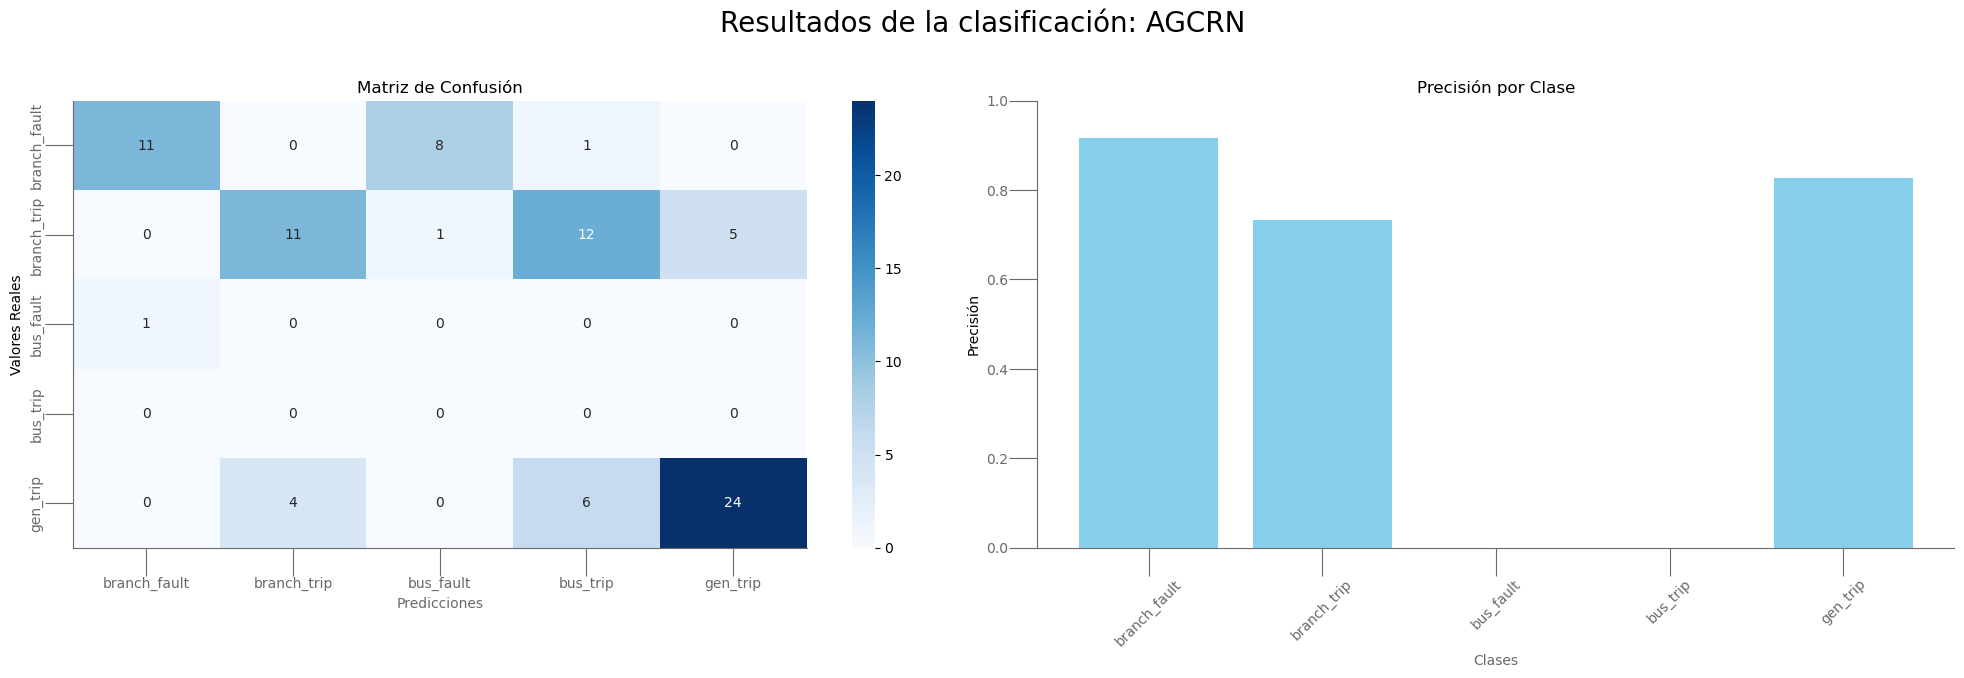

In [ ]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "MSTGCN")

In [52]:
name_model ="MSTGCN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0     MPNN_LSTM     {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH       {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH       {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN  {'hidden': 50, 'Embedding': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841   
3  ../experimentos_split/results/clasificacion/aj...  1.344170   1.293829   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.270143       0.600000        0.438630     0.498128  0.435153   
1    1.075731       0.671875        0.630667     0.671140  0.635028   
2    1.076455       0.706667        0.666